# Postprocessing pty-co-SAXSNN for MATLAB (blee SAXS4Assembly + SAXSimageviewer packages)

In [14]:
import pandas as pd
import os
import sys
import torch
import numpy as np
from tqdm import tqdm
import time
import h5py
import random
import matplotlib.pyplot as plt
from matplotlib import colors

# Add parent directory to path for imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src/')))
from utils.ptychosaxsNN_utils import load_h5_scan_to_npy, preprocess_ZCB_9
from utils.create_combined_h5_utils import get_processed_scans, save_to_h5, save_verification_plot,process_scan, add_metadata_to_h5
from models.encoder1 import recon_model 

In [5]:
# Setup parameters for simulated data processing
# Note: Simulated patterns are already 256x256, so no center cropping needed
dpsize = 256
center = None  # Not needed for simulated data (patterns already correct size)

# Simulated data structure parameters
nsteps = 4  # 4x4 grid = 16 patterns per scan
nscans = 180  # Number of tomographic scans
patterns_per_scan = nsteps * nsteps  # 16 patterns per scan

# Model and mask paths
model_path = '../example/03_Train_Validation_Test/trained_model/best_model_Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0_sim_ZCB_9_3D_S5065_N60_steps4_dp256_Unet_epoch_10_pearson_loss.pth'
mask_path = '../data/masks/mask_ZCB_9_3D.npy'

# Load model and mask
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = recon_model()
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Load mask
mask = np.load(mask_path)
print(f"Model and mask loaded successfully")


Using device: cuda
Model and mask loaded successfully


In [6]:
# Run deconvolution for simulated tomographic scan data
h5_path = '/net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/example/01_Data_Generation/Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans180_centerConc0.50_NoiseOn_Nc10000_tomo_Abs0_PhaseScl1.00_ZCB_9_3D_scan5065/sim_ZCB_9_3D_S5065_N180_steps4_dp256.h5'

# Load simulated patterns from H5 file
print(f"Loading simulated patterns from {h5_path}")
with h5py.File(h5_path, 'r') as f:
    convoluted_patterns = f['convDP'][:]  # Load entire array into memory
    ideal_patterns = f['idealDP'][:]  # Load entire array into memory

n_patterns = len(convoluted_patterns)
print(f"Loaded {n_patterns} simulated patterns")
print(f"Pattern shape: {convoluted_patterns[0].shape}")
print(f"Expected: {nscans} scans × {patterns_per_scan} patterns/scan = {nscans * patterns_per_scan} total patterns")

# Verify the number of patterns matches expected structure
if n_patterns != nscans * patterns_per_scan:
    print(f"Warning: Expected {nscans * patterns_per_scan} patterns, but found {n_patterns}")
    print(f"Adjusting nscans to match data: {n_patterns // patterns_per_scan}")
    nscans = n_patterns // patterns_per_scan

# Output H5 file (no scan_name needed for simulated data)
output_file = f'../example/05_Postprocessing/combined_diffraction_patterns_{model_path.split("/")[-1].split(".")[0]}_sim.h5'
print(f'Output file: {output_file}')

# For simulated data, group patterns by scan (each scan has patterns_per_scan patterns)
# Get already processed scans
processed_scans = get_processed_scans(output_file)
all_scan_numbers = list(range(nscans))
remaining_scans = [s for s in all_scan_numbers if s not in processed_scans]
print(f"Found {len(processed_scans)} already processed scans. {len(remaining_scans)} scans remaining.")

# Add delay parameter (optional, for I/O throttling)
delay_between_scans = 0.0  # seconds (set to 0 for simulated data, can increase if needed)

# Process remaining scans sequentially
# Each scan processes patterns_per_scan patterns and sums them
results = []
for scan_idx in tqdm(remaining_scans, desc="Processing scans"):
    # Calculate pattern indices for this scan
    # Scan 0: patterns 0-15, Scan 1: patterns 16-31, etc.
    start_pattern_idx = scan_idx * patterns_per_scan
    end_pattern_idx = (scan_idx + 1) * patterns_per_scan
    pattern_indices = list(range(start_pattern_idx, end_pattern_idx))
    
    # Process all patterns for this scan (will be summed internally)
    result = process_scan(
        scan_number=pattern_indices,  # Pass list of pattern indices for this scan
        base_path=None,
        model=model,
        device=device,
        center=center,
        dpsize=dpsize,
        mask=mask,
        indices_file=None,
        exp_data=False,  # Use simulated data mode
        sim_dps=convoluted_patterns  # Pass simulated patterns
    )
    if result is not None:
        # Update scan_number in result to be the scan index (not pattern indices)
        result['scan_number'] = scan_idx
        results.append(result)
        save_verification_plot(result)
        save_to_h5(output_file, result)
    
    if scan_idx != remaining_scans[-1] and delay_between_scans > 0:
        time.sleep(delay_between_scans)

print(f"Processing complete. Results saved to {output_file}")
print(f"Processed {len(results)} scans successfully (each scan summed {patterns_per_scan} patterns).")

Loading simulated patterns from /net/micdata/data2/12IDC/ptychosaxs/ptycoSAXSNN/example/01_Data_Generation/Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans180_centerConc0.50_NoiseOn_Nc10000_tomo_Abs0_PhaseScl1.00_ZCB_9_3D_scan5065/sim_ZCB_9_3D_S5065_N180_steps4_dp256.h5
Loaded 2880 simulated patterns
Pattern shape: (256, 256)
Expected: 180 scans × 16 patterns/scan = 2880 total patterns
Output file: ../example/05_Postprocessing/combined_diffraction_patterns_best_model_Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0_sim_ZCB_9_3D_S5065_N60_steps4_dp256_Unet_epoch_10_pearson_loss_sim.h5
Found 0 already processed scans. 180 scans remaining.


Processing scans:   0%|          | 0/180 [00:00<?, ?it/s]

Processing 16 patterns (indices 0-15) - will be summed


Processing scans:   1%|          | 1/180 [00:00<02:21,  1.26it/s]

Processing 16 patterns (indices 16-31) - will be summed


Processing scans:   1%|          | 2/180 [00:01<02:10,  1.37it/s]

Processing 16 patterns (indices 32-47) - will be summed


Processing scans:   2%|▏         | 3/180 [00:02<02:06,  1.40it/s]

Processing 16 patterns (indices 48-63) - will be summed


Processing scans:   2%|▏         | 4/180 [00:02<02:03,  1.42it/s]

Processing 16 patterns (indices 64-79) - will be summed


Processing scans:   3%|▎         | 5/180 [00:03<02:02,  1.43it/s]

Processing 16 patterns (indices 80-95) - will be summed


Processing scans:   3%|▎         | 6/180 [00:04<02:01,  1.43it/s]

Processing 16 patterns (indices 96-111) - will be summed


Processing scans:   4%|▍         | 7/180 [00:04<02:01,  1.43it/s]

Processing 16 patterns (indices 112-127) - will be summed


Processing scans:   4%|▍         | 8/180 [00:05<02:02,  1.40it/s]

Processing 16 patterns (indices 128-143) - will be summed


Processing scans:   5%|▌         | 9/180 [00:07<02:40,  1.07it/s]

Processing 16 patterns (indices 144-159) - will be summed


Processing scans:   6%|▌         | 10/180 [00:07<02:27,  1.16it/s]

Processing 16 patterns (indices 160-175) - will be summed


Processing scans:   6%|▌         | 11/180 [00:08<02:19,  1.21it/s]

Processing 16 patterns (indices 176-191) - will be summed


Processing scans:   7%|▋         | 12/180 [00:09<02:12,  1.27it/s]

Processing 16 patterns (indices 192-207) - will be summed


Processing scans:   7%|▋         | 13/180 [00:09<02:08,  1.30it/s]

Processing 16 patterns (indices 208-223) - will be summed


Processing scans:   8%|▊         | 14/180 [00:10<02:19,  1.19it/s]

Processing 16 patterns (indices 224-239) - will be summed


Processing scans:   8%|▊         | 15/180 [00:11<02:14,  1.23it/s]

Processing 16 patterns (indices 240-255) - will be summed


Processing scans:   9%|▉         | 16/180 [00:12<02:07,  1.29it/s]

Processing 16 patterns (indices 256-271) - will be summed


Processing scans:   9%|▉         | 17/180 [00:13<02:03,  1.32it/s]

Processing 16 patterns (indices 272-287) - will be summed


Processing scans:  10%|█         | 18/180 [00:13<01:59,  1.36it/s]

Processing 16 patterns (indices 288-303) - will be summed


Processing scans:  11%|█         | 19/180 [00:14<01:56,  1.38it/s]

Processing 16 patterns (indices 304-319) - will be summed


Processing scans:  11%|█         | 20/180 [00:15<02:10,  1.22it/s]

Processing 16 patterns (indices 320-335) - will be summed


Processing scans:  12%|█▏        | 21/180 [00:16<02:06,  1.26it/s]

Processing 16 patterns (indices 336-351) - will be summed


Processing scans:  12%|█▏        | 22/180 [00:17<02:15,  1.17it/s]

Processing 16 patterns (indices 352-367) - will be summed


Processing scans:  13%|█▎        | 23/180 [00:18<02:09,  1.21it/s]

Processing 16 patterns (indices 368-383) - will be summed


Processing scans:  13%|█▎        | 24/180 [00:18<02:02,  1.28it/s]

Processing 16 patterns (indices 384-399) - will be summed


Processing scans:  14%|█▍        | 25/180 [00:19<01:58,  1.31it/s]

Processing 16 patterns (indices 400-415) - will be summed


Processing scans:  14%|█▍        | 26/180 [00:20<01:55,  1.33it/s]

Processing 16 patterns (indices 416-431) - will be summed


Processing scans:  15%|█▌        | 27/180 [00:20<01:53,  1.35it/s]

Processing 16 patterns (indices 432-447) - will be summed


Processing scans:  16%|█▌        | 28/180 [00:21<01:50,  1.38it/s]

Processing 16 patterns (indices 448-463) - will be summed


Processing scans:  16%|█▌        | 29/180 [00:22<01:49,  1.38it/s]

Processing 16 patterns (indices 464-479) - will be summed


Processing scans:  17%|█▋        | 30/180 [00:23<02:07,  1.18it/s]

Processing 16 patterns (indices 480-495) - will be summed


Processing scans:  17%|█▋        | 31/180 [00:24<02:01,  1.22it/s]

Processing 16 patterns (indices 496-511) - will be summed


Processing scans:  18%|█▊        | 32/180 [00:24<01:55,  1.28it/s]

Processing 16 patterns (indices 512-527) - will be summed


Processing scans:  18%|█▊        | 33/180 [00:25<01:50,  1.33it/s]

Processing 16 patterns (indices 528-543) - will be summed


Processing scans:  19%|█▉        | 34/180 [00:26<01:47,  1.36it/s]

Processing 16 patterns (indices 544-559) - will be summed


Processing scans:  19%|█▉        | 35/180 [00:27<01:47,  1.35it/s]

Processing 16 patterns (indices 560-575) - will be summed


Processing scans:  20%|██        | 36/180 [00:27<01:46,  1.35it/s]

Processing 16 patterns (indices 576-591) - will be summed


Processing scans:  21%|██        | 37/180 [00:28<01:45,  1.35it/s]

Processing 16 patterns (indices 592-607) - will be summed


Processing scans:  21%|██        | 38/180 [00:29<01:45,  1.35it/s]

Processing 16 patterns (indices 608-623) - will be summed


Processing scans:  22%|██▏       | 39/180 [00:29<01:42,  1.37it/s]

Processing 16 patterns (indices 624-639) - will be summed


Processing scans:  22%|██▏       | 40/180 [00:30<01:41,  1.38it/s]

Processing 16 patterns (indices 640-655) - will be summed


Processing scans:  23%|██▎       | 41/180 [00:31<02:01,  1.14it/s]

Processing 16 patterns (indices 656-671) - will be summed


Processing scans:  23%|██▎       | 42/180 [00:32<01:54,  1.20it/s]

Processing 16 patterns (indices 672-687) - will be summed


Processing scans:  24%|██▍       | 43/180 [00:33<01:49,  1.25it/s]

Processing 16 patterns (indices 688-703) - will be summed


Processing scans:  24%|██▍       | 44/180 [00:34<01:45,  1.28it/s]

Processing 16 patterns (indices 704-719) - will be summed


Processing scans:  25%|██▌       | 45/180 [00:34<01:43,  1.31it/s]

Processing 16 patterns (indices 720-735) - will be summed


Processing scans:  26%|██▌       | 46/180 [00:35<01:41,  1.32it/s]

Processing 16 patterns (indices 736-751) - will be summed


Processing scans:  26%|██▌       | 47/180 [00:36<01:37,  1.36it/s]

Processing 16 patterns (indices 752-767) - will be summed


Processing scans:  27%|██▋       | 48/180 [00:36<01:36,  1.37it/s]

Processing 16 patterns (indices 768-783) - will be summed


Processing scans:  27%|██▋       | 49/180 [00:37<01:34,  1.39it/s]

Processing 16 patterns (indices 784-799) - will be summed


Processing scans:  28%|██▊       | 50/180 [00:38<01:33,  1.39it/s]

Processing 16 patterns (indices 800-815) - will be summed


Processing scans:  28%|██▊       | 51/180 [00:39<01:35,  1.36it/s]

Processing 16 patterns (indices 816-831) - will be summed


Processing scans:  29%|██▉       | 52/180 [00:39<01:35,  1.34it/s]

Processing 16 patterns (indices 832-847) - will be summed


Processing scans:  29%|██▉       | 53/180 [00:40<01:33,  1.36it/s]

Processing 16 patterns (indices 848-863) - will be summed


Processing scans:  30%|███       | 54/180 [00:41<01:55,  1.09it/s]

Processing 16 patterns (indices 864-879) - will be summed


Processing scans:  31%|███       | 55/180 [00:42<01:48,  1.16it/s]

Processing 16 patterns (indices 880-895) - will be summed


Processing scans:  31%|███       | 56/180 [00:43<01:42,  1.21it/s]

Processing 16 patterns (indices 896-911) - will be summed


Processing scans:  32%|███▏      | 57/180 [00:44<01:37,  1.26it/s]

Processing 16 patterns (indices 912-927) - will be summed


Processing scans:  32%|███▏      | 58/180 [00:44<01:34,  1.29it/s]

Processing 16 patterns (indices 928-943) - will be summed


Processing scans:  33%|███▎      | 59/180 [00:45<01:32,  1.31it/s]

Processing 16 patterns (indices 944-959) - will be summed


Processing scans:  33%|███▎      | 60/180 [00:46<01:29,  1.34it/s]

Processing 16 patterns (indices 960-975) - will be summed


Processing scans:  34%|███▍      | 61/180 [00:47<01:28,  1.35it/s]

Processing 16 patterns (indices 976-991) - will be summed


Processing scans:  34%|███▍      | 62/180 [00:47<01:27,  1.35it/s]

Processing 16 patterns (indices 992-1007) - will be summed


Processing scans:  35%|███▌      | 63/180 [00:48<01:24,  1.38it/s]

Processing 16 patterns (indices 1008-1023) - will be summed


Processing scans:  36%|███▌      | 64/180 [00:49<01:24,  1.38it/s]

Processing 16 patterns (indices 1024-1039) - will be summed


Processing scans:  36%|███▌      | 65/180 [00:49<01:24,  1.36it/s]

Processing 16 patterns (indices 1040-1055) - will be summed


Processing scans:  37%|███▋      | 66/180 [00:50<01:23,  1.37it/s]

Processing 16 patterns (indices 1056-1071) - will be summed


Processing scans:  37%|███▋      | 67/180 [00:51<01:21,  1.38it/s]

Processing 16 patterns (indices 1072-1087) - will be summed


Processing scans:  38%|███▊      | 68/180 [00:52<01:21,  1.38it/s]

Processing 16 patterns (indices 1088-1103) - will be summed


Processing scans:  38%|███▊      | 69/180 [00:52<01:20,  1.38it/s]

Processing 16 patterns (indices 1104-1119) - will be summed


Processing scans:  39%|███▉      | 70/180 [00:53<01:19,  1.38it/s]

Processing 16 patterns (indices 1120-1135) - will be summed


Processing scans:  39%|███▉      | 71/180 [00:55<01:44,  1.04it/s]

Processing 16 patterns (indices 1136-1151) - will be summed


Processing scans:  40%|████      | 72/180 [00:55<01:36,  1.12it/s]

Processing 16 patterns (indices 1152-1167) - will be summed


Processing scans:  41%|████      | 73/180 [00:56<01:31,  1.17it/s]

Processing 16 patterns (indices 1168-1183) - will be summed


Processing scans:  41%|████      | 74/180 [00:57<01:26,  1.23it/s]

Processing 16 patterns (indices 1184-1199) - will be summed


Processing scans:  42%|████▏     | 75/180 [00:58<01:25,  1.22it/s]

Processing 16 patterns (indices 1200-1215) - will be summed


Processing scans:  42%|████▏     | 76/180 [00:58<01:25,  1.21it/s]

Processing 16 patterns (indices 1216-1231) - will be summed


Processing scans:  43%|████▎     | 77/180 [00:59<01:21,  1.26it/s]

Processing 16 patterns (indices 1232-1247) - will be summed


Processing scans:  43%|████▎     | 78/180 [01:00<01:23,  1.23it/s]

Processing 16 patterns (indices 1248-1263) - will be summed


Processing scans:  44%|████▍     | 79/180 [01:01<01:20,  1.26it/s]

Processing 16 patterns (indices 1264-1279) - will be summed


Processing scans:  44%|████▍     | 80/180 [01:02<01:16,  1.30it/s]

Processing 16 patterns (indices 1280-1295) - will be summed


Processing scans:  45%|████▌     | 81/180 [01:02<01:15,  1.31it/s]

Processing 16 patterns (indices 1296-1311) - will be summed


Processing scans:  46%|████▌     | 82/180 [01:03<01:13,  1.32it/s]

Processing 16 patterns (indices 1312-1327) - will be summed


Processing scans:  46%|████▌     | 83/180 [01:04<01:13,  1.33it/s]

Processing 16 patterns (indices 1328-1343) - will be summed


Processing scans:  47%|████▋     | 84/180 [01:04<01:12,  1.33it/s]

Processing 16 patterns (indices 1344-1359) - will be summed


Processing scans:  47%|████▋     | 85/180 [01:05<01:11,  1.32it/s]

Processing 16 patterns (indices 1360-1375) - will be summed


Processing scans:  48%|████▊     | 86/180 [01:06<01:10,  1.33it/s]

Processing 16 patterns (indices 1376-1391) - will be summed


Processing scans:  48%|████▊     | 87/180 [01:07<01:10,  1.32it/s]

Processing 16 patterns (indices 1392-1407) - will be summed


Processing scans:  49%|████▉     | 88/180 [01:08<01:08,  1.34it/s]

Processing 16 patterns (indices 1408-1423) - will be summed


Processing scans:  49%|████▉     | 89/180 [01:08<01:07,  1.36it/s]

Processing 16 patterns (indices 1424-1439) - will be summed


Processing scans:  50%|█████     | 90/180 [01:09<01:05,  1.38it/s]

Processing 16 patterns (indices 1440-1455) - will be summed


Processing scans:  51%|█████     | 91/180 [01:11<01:29,  1.01s/it]

Processing 16 patterns (indices 1456-1471) - will be summed


Processing scans:  51%|█████     | 92/180 [01:11<01:22,  1.07it/s]

Processing 16 patterns (indices 1472-1487) - will be summed


Processing scans:  52%|█████▏    | 93/180 [01:12<01:15,  1.15it/s]

Processing 16 patterns (indices 1488-1503) - will be summed


Processing scans:  52%|█████▏    | 94/180 [01:13<01:10,  1.22it/s]

Processing 16 patterns (indices 1504-1519) - will be summed


Processing scans:  53%|█████▎    | 95/180 [01:13<01:06,  1.28it/s]

Processing 16 patterns (indices 1520-1535) - will be summed


Processing scans:  53%|█████▎    | 96/180 [01:14<01:07,  1.24it/s]

Processing 16 patterns (indices 1536-1551) - will be summed


Processing scans:  54%|█████▍    | 97/180 [01:15<01:06,  1.26it/s]

Processing 16 patterns (indices 1552-1567) - will be summed


Processing scans:  54%|█████▍    | 98/180 [01:16<01:03,  1.30it/s]

Processing 16 patterns (indices 1568-1583) - will be summed


Processing scans:  55%|█████▌    | 99/180 [01:17<01:01,  1.32it/s]

Processing 16 patterns (indices 1584-1599) - will be summed


Processing scans:  56%|█████▌    | 100/180 [01:17<01:00,  1.31it/s]

Processing 16 patterns (indices 1600-1615) - will be summed


Processing scans:  56%|█████▌    | 101/180 [01:18<00:59,  1.32it/s]

Processing 16 patterns (indices 1616-1631) - will be summed


Processing scans:  57%|█████▋    | 102/180 [01:19<00:57,  1.35it/s]

Processing 16 patterns (indices 1632-1647) - will be summed


Processing scans:  57%|█████▋    | 103/180 [01:20<00:57,  1.34it/s]

Processing 16 patterns (indices 1648-1663) - will be summed


Processing scans:  58%|█████▊    | 104/180 [01:20<00:56,  1.35it/s]

Processing 16 patterns (indices 1664-1679) - will be summed


Processing scans:  58%|█████▊    | 105/180 [01:21<00:55,  1.35it/s]

Processing 16 patterns (indices 1680-1695) - will be summed


Processing scans:  59%|█████▉    | 106/180 [01:22<00:55,  1.33it/s]

Processing 16 patterns (indices 1696-1711) - will be summed


Processing scans:  59%|█████▉    | 107/180 [01:22<00:54,  1.35it/s]

Processing 16 patterns (indices 1712-1727) - will be summed


Processing scans:  60%|██████    | 108/180 [01:23<00:53,  1.34it/s]

Processing 16 patterns (indices 1728-1743) - will be summed


Processing scans:  61%|██████    | 109/180 [01:24<00:51,  1.37it/s]

Processing 16 patterns (indices 1744-1759) - will be summed


Processing scans:  61%|██████    | 110/180 [01:25<00:50,  1.39it/s]

Processing 16 patterns (indices 1760-1775) - will be summed


Processing scans:  62%|██████▏   | 111/180 [01:25<00:50,  1.37it/s]

Processing 16 patterns (indices 1776-1791) - will be summed


Processing scans:  62%|██████▏   | 112/180 [01:26<00:49,  1.37it/s]

Processing 16 patterns (indices 1792-1807) - will be summed


Processing scans:  63%|██████▎   | 113/180 [01:27<00:48,  1.37it/s]

Processing 16 patterns (indices 1808-1823) - will be summed


Processing scans:  63%|██████▎   | 114/180 [01:28<00:50,  1.30it/s]

Processing 16 patterns (indices 1824-1839) - will be summed


Processing scans:  64%|██████▍   | 115/180 [01:30<01:12,  1.11s/it]

Processing 16 patterns (indices 1840-1855) - will be summed


Processing scans:  64%|██████▍   | 116/180 [01:30<01:04,  1.00s/it]

Processing 16 patterns (indices 1856-1871) - will be summed


Processing scans:  65%|██████▌   | 117/180 [01:31<00:58,  1.08it/s]

Processing 16 patterns (indices 1872-1887) - will be summed


Processing scans:  66%|██████▌   | 118/180 [01:32<00:53,  1.16it/s]

Processing 16 patterns (indices 1888-1903) - will be summed


Processing scans:  66%|██████▌   | 119/180 [01:33<00:50,  1.22it/s]

Processing 16 patterns (indices 1904-1919) - will be summed


Processing scans:  67%|██████▋   | 120/180 [01:33<00:48,  1.24it/s]

Processing 16 patterns (indices 1920-1935) - will be summed


Processing scans:  67%|██████▋   | 121/180 [01:34<00:45,  1.29it/s]

Processing 16 patterns (indices 1936-1951) - will be summed


Processing scans:  68%|██████▊   | 122/180 [01:35<00:44,  1.30it/s]

Processing 16 patterns (indices 1952-1967) - will be summed


Processing scans:  68%|██████▊   | 123/180 [01:36<00:43,  1.30it/s]

Processing 16 patterns (indices 1968-1983) - will be summed


Processing scans:  69%|██████▉   | 124/180 [01:36<00:42,  1.32it/s]

Processing 16 patterns (indices 1984-1999) - will be summed


Processing scans:  69%|██████▉   | 125/180 [01:37<00:41,  1.32it/s]

Processing 16 patterns (indices 2000-2015) - will be summed


Processing scans:  70%|███████   | 126/180 [01:38<00:40,  1.32it/s]

Processing 16 patterns (indices 2016-2031) - will be summed


Processing scans:  71%|███████   | 127/180 [01:39<00:39,  1.33it/s]

Processing 16 patterns (indices 2032-2047) - will be summed


Processing scans:  71%|███████   | 128/180 [01:39<00:38,  1.33it/s]

Processing 16 patterns (indices 2048-2063) - will be summed


Processing scans:  72%|███████▏  | 129/180 [01:40<00:38,  1.34it/s]

Processing 16 patterns (indices 2064-2079) - will be summed


Processing scans:  72%|███████▏  | 130/180 [01:41<00:38,  1.29it/s]

Processing 16 patterns (indices 2080-2095) - will be summed


Processing scans:  73%|███████▎  | 131/180 [01:42<00:37,  1.30it/s]

Processing 16 patterns (indices 2096-2111) - will be summed


Processing scans:  73%|███████▎  | 132/180 [01:42<00:36,  1.30it/s]

Processing 16 patterns (indices 2112-2127) - will be summed


Processing scans:  74%|███████▍  | 133/180 [01:43<00:36,  1.27it/s]

Processing 16 patterns (indices 2128-2143) - will be summed


Processing scans:  74%|███████▍  | 134/180 [01:44<00:35,  1.31it/s]

Processing 16 patterns (indices 2144-2159) - will be summed


Processing scans:  75%|███████▌  | 135/180 [01:45<00:34,  1.32it/s]

Processing 16 patterns (indices 2160-2175) - will be summed


Processing scans:  76%|███████▌  | 136/180 [01:45<00:33,  1.32it/s]

Processing 16 patterns (indices 2176-2191) - will be summed


Processing scans:  76%|███████▌  | 137/180 [01:46<00:32,  1.32it/s]

Processing 16 patterns (indices 2192-2207) - will be summed


Processing scans:  77%|███████▋  | 138/180 [01:47<00:32,  1.31it/s]

Processing 16 patterns (indices 2208-2223) - will be summed


Processing scans:  77%|███████▋  | 139/180 [01:48<00:31,  1.32it/s]

Processing 16 patterns (indices 2224-2239) - will be summed


Processing scans:  78%|███████▊  | 140/180 [01:48<00:29,  1.34it/s]

Processing 16 patterns (indices 2240-2255) - will be summed


Processing scans:  78%|███████▊  | 141/180 [01:49<00:29,  1.34it/s]

Processing 16 patterns (indices 2256-2271) - will be summed


Processing scans:  79%|███████▉  | 142/180 [01:50<00:27,  1.37it/s]

Processing 16 patterns (indices 2272-2287) - will be summed


Processing scans:  79%|███████▉  | 143/180 [01:51<00:27,  1.36it/s]

Processing 16 patterns (indices 2288-2303) - will be summed


Processing scans:  80%|████████  | 144/180 [01:51<00:26,  1.36it/s]

Processing 16 patterns (indices 2304-2319) - will be summed


Processing scans:  81%|████████  | 145/180 [01:52<00:25,  1.38it/s]

Processing 16 patterns (indices 2320-2335) - will be summed


Processing scans:  81%|████████  | 146/180 [01:54<00:39,  1.15s/it]

Processing 16 patterns (indices 2336-2351) - will be summed


Processing scans:  82%|████████▏ | 147/180 [01:55<00:33,  1.02s/it]

Processing 16 patterns (indices 2352-2367) - will be summed


Processing scans:  82%|████████▏ | 148/180 [01:56<00:29,  1.08it/s]

Processing 16 patterns (indices 2368-2383) - will be summed


Processing scans:  83%|████████▎ | 149/180 [01:56<00:27,  1.15it/s]

Processing 16 patterns (indices 2384-2399) - will be summed


Processing scans:  83%|████████▎ | 150/180 [01:57<00:24,  1.21it/s]

Processing 16 patterns (indices 2400-2415) - will be summed


Processing scans:  84%|████████▍ | 151/180 [01:58<00:23,  1.24it/s]

Processing 16 patterns (indices 2416-2431) - will be summed


Processing scans:  84%|████████▍ | 152/180 [01:59<00:22,  1.27it/s]

Processing 16 patterns (indices 2432-2447) - will be summed


Processing scans:  85%|████████▌ | 153/180 [01:59<00:21,  1.28it/s]

Processing 16 patterns (indices 2448-2463) - will be summed


Processing scans:  86%|████████▌ | 154/180 [02:00<00:20,  1.27it/s]

Processing 16 patterns (indices 2464-2479) - will be summed


Processing scans:  86%|████████▌ | 155/180 [02:01<00:19,  1.28it/s]

Processing 16 patterns (indices 2480-2495) - will be summed


Processing scans:  87%|████████▋ | 156/180 [02:02<00:19,  1.25it/s]

Processing 16 patterns (indices 2496-2511) - will be summed


Processing scans:  87%|████████▋ | 157/180 [02:03<00:18,  1.26it/s]

Processing 16 patterns (indices 2512-2527) - will be summed


Processing scans:  88%|████████▊ | 158/180 [02:03<00:16,  1.30it/s]

Processing 16 patterns (indices 2528-2543) - will be summed


Processing scans:  88%|████████▊ | 159/180 [02:04<00:16,  1.29it/s]

Processing 16 patterns (indices 2544-2559) - will be summed


Processing scans:  89%|████████▉ | 160/180 [02:05<00:15,  1.33it/s]

Processing 16 patterns (indices 2560-2575) - will be summed


Processing scans:  89%|████████▉ | 161/180 [02:05<00:14,  1.32it/s]

Processing 16 patterns (indices 2576-2591) - will be summed


Processing scans:  90%|█████████ | 162/180 [02:06<00:13,  1.34it/s]

Processing 16 patterns (indices 2592-2607) - will be summed


Processing scans:  91%|█████████ | 163/180 [02:07<00:12,  1.33it/s]

Processing 16 patterns (indices 2608-2623) - will be summed


Processing scans:  91%|█████████ | 164/180 [02:08<00:11,  1.33it/s]

Processing 16 patterns (indices 2624-2639) - will be summed


Processing scans:  92%|█████████▏| 165/180 [02:08<00:11,  1.36it/s]

Processing 16 patterns (indices 2640-2655) - will be summed


Processing scans:  92%|█████████▏| 166/180 [02:09<00:10,  1.35it/s]

Processing 16 patterns (indices 2656-2671) - will be summed


Processing scans:  93%|█████████▎| 167/180 [02:10<00:09,  1.33it/s]

Processing 16 patterns (indices 2672-2687) - will be summed


Processing scans:  93%|█████████▎| 168/180 [02:11<00:08,  1.34it/s]

Processing 16 patterns (indices 2688-2703) - will be summed


Processing scans:  94%|█████████▍| 169/180 [02:11<00:08,  1.34it/s]

Processing 16 patterns (indices 2704-2719) - will be summed


Processing scans:  94%|█████████▍| 170/180 [02:12<00:07,  1.36it/s]

Processing 16 patterns (indices 2720-2735) - will be summed


Processing scans:  95%|█████████▌| 171/180 [02:13<00:06,  1.34it/s]

Processing 16 patterns (indices 2736-2751) - will be summed


Processing scans:  96%|█████████▌| 172/180 [02:14<00:06,  1.33it/s]

Processing 16 patterns (indices 2752-2767) - will be summed


Processing scans:  96%|█████████▌| 173/180 [02:15<00:05,  1.25it/s]

Processing 16 patterns (indices 2768-2783) - will be summed


Processing scans:  97%|█████████▋| 174/180 [02:15<00:04,  1.26it/s]

Processing 16 patterns (indices 2784-2799) - will be summed


Processing scans:  97%|█████████▋| 175/180 [02:16<00:04,  1.24it/s]

Processing 16 patterns (indices 2800-2815) - will be summed


Processing scans:  98%|█████████▊| 176/180 [02:17<00:03,  1.27it/s]

Processing 16 patterns (indices 2816-2831) - will be summed


Processing scans:  98%|█████████▊| 177/180 [02:18<00:02,  1.31it/s]

Processing 16 patterns (indices 2832-2847) - will be summed


Processing scans:  99%|█████████▉| 178/180 [02:18<00:01,  1.34it/s]

Processing 16 patterns (indices 2848-2863) - will be summed


Processing scans:  99%|█████████▉| 179/180 [02:19<00:00,  1.37it/s]

Processing 16 patterns (indices 2864-2879) - will be summed


Processing scans: 100%|██████████| 180/180 [02:20<00:00,  1.28it/s]

Processing complete. Results saved to ../example/05_Postprocessing/combined_diffraction_patterns_best_model_Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0_sim_ZCB_9_3D_S5065_N60_steps4_dp256_Unet_epoch_10_pearson_loss_sim.h5
Processed 180 scans successfully (each scan summed 16 patterns).


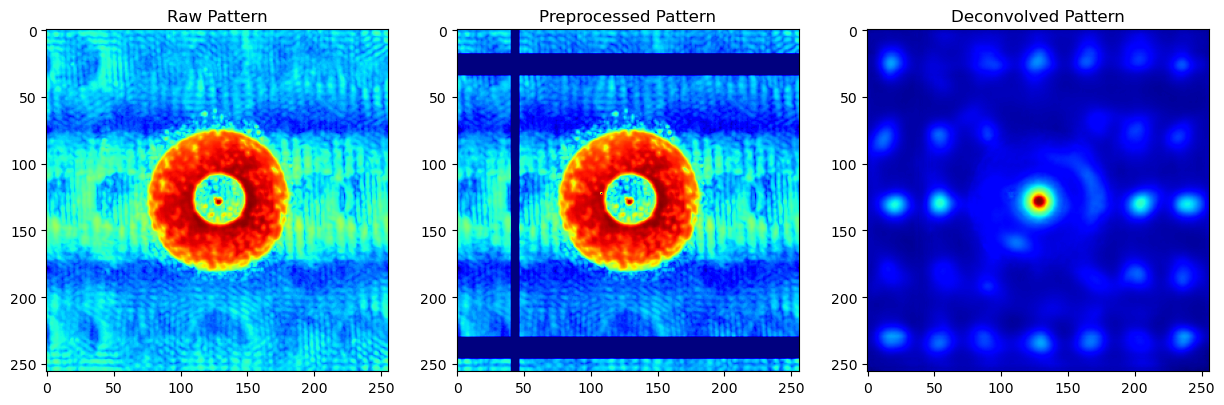

In [18]:
with h5py.File(output_file, 'r') as f:
    preprocessed = f['preprocessed']
    raw = f['raw']
    deconvolved = f['deconvolved']

    ri = random.randint(0, 180)
    preprocessed_pattern = preprocessed['scan_{}'.format(ri)]
    raw_pattern = raw['scan_{}'.format(ri)]
    deconvolved_pattern = deconvolved['scan_{}'.format(ri)]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(raw_pattern, cmap='jet', norm=colors.LogNorm())
    ax[0].set_title('Raw Pattern')
    ax[1].imshow(preprocessed_pattern, cmap='jet', norm=colors.LogNorm())
    ax[1].set_title('Preprocessed Pattern')
    ax[2].imshow(deconvolved_pattern, cmap='jet', norm=colors.LogNorm())
    ax[2].set_title('Deconvolved Pattern')
    plt.show()